# Deep Learning Face Mask Detection

## Introduction

For my project I used the ‘CM3015 Machine Learning and Neural Networks Project Idea Title 1: Deep Learning on a public dataset’ template. I started the project by using OpenCV to be able to read in image or video content of human faces. I used Tensorflow and Keras to build and train a deep learning Convolutional Neural Network that can identify whether the faces are wearing a mask or not. I treated the problem as a binary image classification problem. In order to improve the accuracy and precision of my model I added more layers, adjusted the number of epochs and then included a pre-trained model. Finally I will use Gradio to deploy a user-friendly application that can be used by business employees to upload and see the results of the model. 

## Creating the mask detection deep learning model

We will now look into building a Deep Learning model to predict (detect) if a person is violating the rules by not wearing a mask. 

### Step 1: Importing the necessary Python libraries

In [2]:
!python3 -m pip install keras tensorflow gradio matplotlib opencv-python numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 74.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 77.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 7.3 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77044 sha256=f1216dc45e997a2aed9d7251808353ebefd2d671d7ba0a1cfeba2f7fbf4fe0a3
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37

In [3]:
# To check if GPU is active
from tensorflow.python.client import device_lib

# Load Data
import os
import cv2
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt

# Model Deployment
import gradio as gr

# Model Training
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Step 2: Getting the data

For the training data, we are using the face mask detection data from [here](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset). The dataset contains 12 thousand images divided into Test, Train, and Validation sets which were scraped from Google and the CelebFace dataset created by [Jessica Li ](https://www.kaggle.com/jessicali9530). To start using it, I downloaded the dataset and saved it in the working directory.

In [4]:
# Load train and test set
train_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
test_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
val_dir = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

### Step 3: Reading a sample image and performing face detection

We will now read in a sample image from a busy airport and perform face detection using haar cascade classifier. The [Haar cascade classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originally known as the Viola-Jones Face Detection Technique is a object detection algorithm for detecting faces in images or real-time video. 

Viola and Jones proposed edge or line detection features in their research paper "Rapid Object Detection using a Boosted Cascade of Simple Features," published in 2001. The algorithm is given a large number of positive photos with faces and a large number of negative images with no faces. The model developed as a result of this training can be found in the OpenCV GitHub [repository](https://github.com/opencv/opencv/tree/master/data/haarcascades).

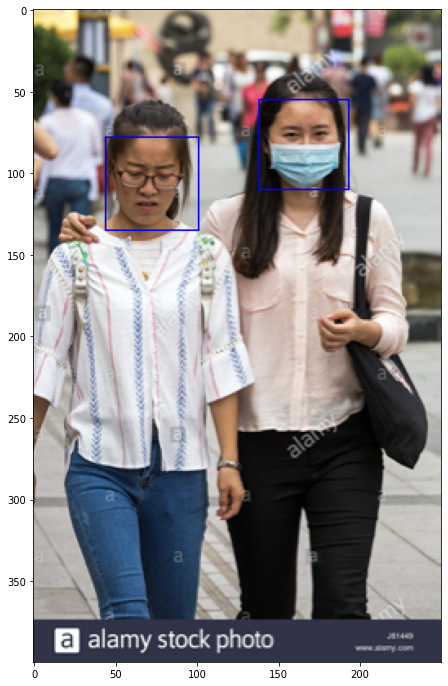

In [5]:
# Read a sample image
img = cv2.imread("../input/face-mask-detection/images/maksssksksss352.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

### Step 4: Data preprocessing for building the mask detection Keras model

We will now pass our datasets into Keras [ImageDataGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to perform some preliminary data augmentation steps such as rescaling. 

We normalise the values by dividing the image pixel values by 255. 

In [6]:
# Data preprocessing
# Train data
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Step 5: Creating a baseline model for mask detection using Keras

We'll start out by creating a baseline model. Since this is a binary classification problem we will use sigmoid last layer activation and a binary_crossentropy loss function.We will do this based on this chart from the 'deep learning with python' book. 

We also choose to use a Convulted Neural Netwiork, which is ideal for image data. A convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In this case, we’ll configure the convnet to process inputs of size (128, 128, 3), which is the format of the images. We’ll do this by passing the argument input_shape=(128, 128, 3) to the first layer. We'll also add in some pooling layers which are appropriate for image classification problems (link in book)

In [7]:
from keras import layers
from keras import models

from keras import layers
from keras import models

model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.Flatten())
model_1.add(Dense(2, activation="sigmoid"))

Here's a look at the model to start. 

In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [8]:
# Compiling the model
model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [9]:
#16 and 8

# Fit the model on train data along with validation data
model_1_history = model_1.fit(
    train_generator,
    steps_per_epoch=1000 // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=800 // 32
)

Epoch 1/5
31/31 [==============================] - 23s 523ms/step - loss: 0.3677 - accuracy: 0.8407 - val_loss: 0.2570 - val_accuracy: 0.8913
Epoch 2/5
31/31 [==============================] - 13s 426ms/step - loss: 0.1756 - accuracy: 0.9375 - val_loss: 0.1487 - val_accuracy: 0.9388
Epoch 3/5
31/31 [==============================] - 12s 381ms/step - loss: 0.1807 - accuracy: 0.9385 - val_loss: 0.2288 - val_accuracy: 0.9100
Epoch 4/5
31/31 [==============================] - 12s 386ms/step - loss: 0.1253 - accuracy: 0.9556 - val_loss: 0.0804 - val_accuracy: 0.9762
Epoch 5/5
31/31 [==============================] - 11s 372ms/step - loss: 0.0864 - accuracy: 0.9693 - val_loss: 0.0636 - val_accuracy: 0.9800


## Step 6: Evaluating the model

We'll now create an initial visualisation to help measure our progress. We'll be using holdout validation. 

In [44]:
# Evaluate model performance on test data
model_1_loss, model_1_acc = model_1.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_1_loss, model_1_acc*100))

25/25 [==============================] - 4s 155ms/step - loss: 0.0872 - accuracy: 0.9663
Model has a loss of 0.09 and accuracy 96.63%


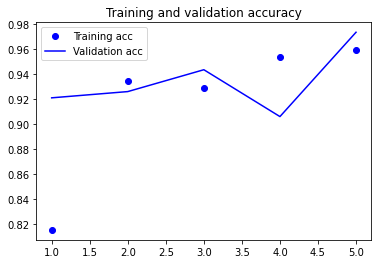

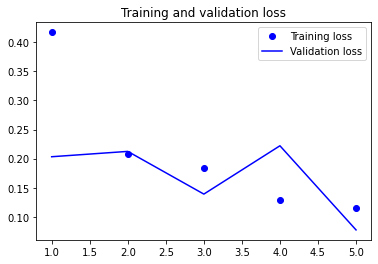

In [72]:
import matplotlib.pyplot as plt

acc = model_1_history.history['accuracy']
val_acc = model_1_history.history['val_accuracy']
loss = model_1_history.history['loss']
val_loss = model_1_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our model can clearly be improved. We can see that accuracy peaks at around 4 epochs. We also see that the model is overfitted. Let's go ahead and save it as best practice and address some of these initial concerns. 

In [13]:
model_1.save('data/mask_model_1.h5')

## 7. Deploying the baseline model using Gradio

In [77]:
def detection(image):
    # label for mask detection
    mask_det_label = {0: "Mask", 1: "No Mask"}
    mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
    pad_y = 1  # padding for result text

    main_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # colored output image
    
    # loading haarcascade_frontalface_default.xml
    face_detection_model = cv2.CascadeClassifier("../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")
    
    # detect faces in the given image
    return_faces = face_detection_model.detectMultiScale(
    main_img, scaleFactor=1.08, minNeighbors=4
    )  # returns a list of (x,y,w,h) tuples


    # For detected faces in the image
    for i in range(len(return_faces)):
        (x, y, w, h) = return_faces[i]
        cropped_face = main_img[y : y + h, x : x + w]
        cropped_face = cv2.resize(cropped_face, (128, 128))
        cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
        # make model prediction
        mask_result = model_1.predict(cropped_face)  
        print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
        label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

        # Print result
        (t_w, t_h), _ = cv2.getTextSize(
            print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
        )  # getting the text size

        cv2.rectangle(
            image,
            (x, y + pad_y),
            (x + t_w, y - t_h - pad_y - 6),
            label_colour,
            -1,
        )  # draw rectangle

        cv2.putText(
            image,
            print_label,
            (x, y - 6),
            cv2.FONT_HERSHEY_DUPLEX,
            0.4,
            (255, 255, 255), # white
            1,
        )  # print text

        cv2.rectangle(
            image,
            (x, y),
            (x + w, y + h),
            label_colour,
            1,
        )  # draw bounding box on face

        return image

demo = gr.Interface(detection, gr.Image(), gr.Image())
demo.launch()

Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7864
Running on public URL: https://d69fee5d47cfe4af2d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## 8. Improving on the model

### Add more layers and adjust epoch number 

Let's start by adding more layers, adjusting the epochs, and we'll also add a dropout layer to prevent overfitting. 

In [10]:

model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(2, activation='sigmoid'))


In [11]:
model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [49]:
#16 and 10 

# Fit the model on train data along with validation data
model_2_history = model_2.fit(
    train_generator,
    steps_per_epoch=1000 // 32,
    epochs=6,
    validation_data=val_generator,
    validation_steps=800 // 32
)


Epoch 1/6
31/31 [==============================] - 11s 353ms/step - loss: 0.1478 - accuracy: 0.9536 - val_loss: 0.1389 - val_accuracy: 0.9450
Epoch 2/6
31/31 [==============================] - 10s 341ms/step - loss: 0.1377 - accuracy: 0.9496 - val_loss: 0.0986 - val_accuracy: 0.9613
Epoch 3/6
31/31 [==============================] - 10s 337ms/step - loss: 0.1065 - accuracy: 0.9698 - val_loss: 0.0942 - val_accuracy: 0.9762
Epoch 4/6
31/31 [==============================] - 10s 339ms/step - loss: 0.1090 - accuracy: 0.9577 - val_loss: 0.1235 - val_accuracy: 0.9475
Epoch 5/6
31/31 [==============================] - 10s 329ms/step - loss: 0.1328 - accuracy: 0.9587 - val_loss: 0.0746 - val_accuracy: 0.9812
Epoch 6/6
31/31 [==============================] - 10s 328ms/step - loss: 0.1249 - accuracy: 0.9597 - val_loss: 0.0892 - val_accuracy: 0.9812


In [50]:
# Evaluate model performance on test data
model_2_loss, model_2_acc = model_2.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_2_loss, model_2_acc*100))

25/25 [==============================] - 4s 157ms/step - loss: 0.0879 - accuracy: 0.9812
Model has a loss of 0.09 and accuracy 98.12%


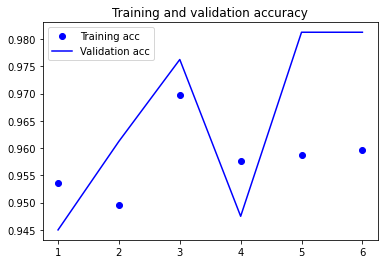

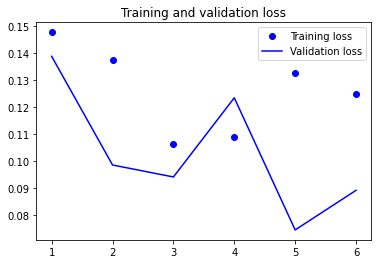

In [51]:
import matplotlib.pyplot as plt

acc = model_2_history.history['accuracy']
val_acc = model_2_history.history['val_accuracy']
loss = model_2_history.history['loss']
val_loss = model_2_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Our accuracy has gone up to 98.12%! Great, let's see if we can imrpove on this even more. We'll save the model for the moment. 

In [52]:
model_2.save('data/mask_model_2.h5')

### Adding a pre-trained network

We'll use the VGG19 pre-trained model and also increase the number of epochs to try and improve performance. 

Let's initialize the model and compile it. 


In [12]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model_3 = Sequential()
model_3.add(vgg19_model)
model_3.add(Flatten())
model_3.add(Dense(2, activation="sigmoid"))
model_3.summary()

# Compiling the model
model_3.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

80150528/80134624 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model

We will now train our neural network model for 20 epochs.

In [91]:
# Fit the model on train data along with validation data
model_3_history = model_3.fit_generator(
    generator=train_generator,
    steps_per_epoch=1000 // 32,
    epochs=10,
    validation_data=val_generator,
    validation_steps=800 // 32,
)

Epoch 1/10
31/31 [==============================] - 11s 360ms/step - loss: 0.0428 - accuracy: 0.9859 - val_loss: 0.0283 - val_accuracy: 0.9925
Epoch 2/10
31/31 [==============================] - 10s 322ms/step - loss: 0.0495 - accuracy: 0.9816 - val_loss: 0.0362 - val_accuracy: 0.9875
Epoch 3/10
31/31 [==============================] - 10s 325ms/step - loss: 0.0396 - accuracy: 0.9849 - val_loss: 0.0237 - val_accuracy: 0.9912
Epoch 4/10
31/31 [==============================] - 11s 343ms/step - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.0288 - val_accuracy: 0.9925
Epoch 5/10
31/31 [==============================] - 10s 325ms/step - loss: 0.0231 - accuracy: 0.9940 - val_loss: 0.0227 - val_accuracy: 0.9950
Epoch 6/10
31/31 [==============================] - 10s 340ms/step - loss: 0.0197 - accuracy: 0.9980 - val_loss: 0.0255 - val_accuracy: 0.9937
Epoch 7/10
31/31 [==============================] - 10s 325ms/step - loss: 0.0353 - accuracy: 0.9899 - val_loss: 0.0363 - val_accuracy: 0.9887

## Evaluate the model

In [89]:
# Evaluate model performance on test data
model_loss, model_acc = model_3.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 4s 165ms/step - loss: 0.0250 - accuracy: 0.9937
Model has a loss of 0.03 and accuracy 99.37%


Awesome! We're getting an accuracy of 99.37% by using a pre-trained model and by increaing the epochs

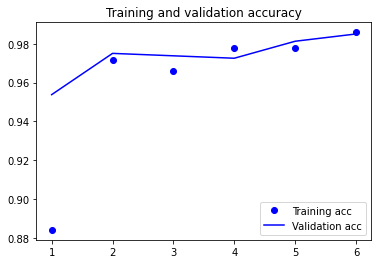

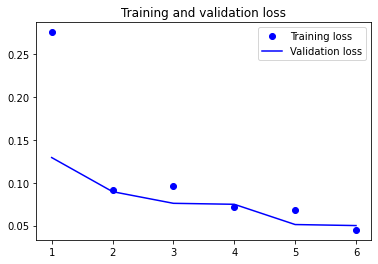

In [19]:
import matplotlib.pyplot as plt

acc = model_3_history.history['accuracy']
val_acc = model_3_history.history['val_accuracy']
loss = model_3_history.history['loss']
val_loss = model_3_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Save the model

We can also choose to save the trained model as a h5 file for future use.

In [20]:
model_3.save('data/mask_model_3.h5')

## Evaluate model using Tensorboard 

We should be able to improve the model performance even more and one way of doing this is to monitor accuracy and loss better over time. I will use Tensorboard for this

In [13]:
%load_ext tensorboard

In [14]:
import tensorflow as tf
import datetime

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
# model.fit(x=x_train, 
#           y=y_train, 
#           epochs=3, 
#           validation_data=(x_test, y_test), 
#           callbacks=[tensorboard_callback])

# Fit the model on train data along with validation data
model_3_history = model_3.fit(
    train_generator,
    steps_per_epoch=1000 // 32,
    epochs=6,
    validation_data=val_generator,
    validation_steps=800 // 32,
    callbacks=[tensorboard_callback]
)


Epoch 1/6
31/31 [==============================] - 13s 387ms/step - loss: 0.2750 - accuracy: 0.8841 - val_loss: 0.1292 - val_accuracy: 0.9538
Epoch 2/6
31/31 [==============================] - 11s 372ms/step - loss: 0.0920 - accuracy: 0.9718 - val_loss: 0.0896 - val_accuracy: 0.9750
Epoch 3/6
31/31 [==============================] - 11s 349ms/step - loss: 0.0959 - accuracy: 0.9657 - val_loss: 0.0760 - val_accuracy: 0.9737
Epoch 4/6
31/31 [==============================] - 11s 364ms/step - loss: 0.0718 - accuracy: 0.9778 - val_loss: 0.0748 - val_accuracy: 0.9725
Epoch 5/6
31/31 [==============================] - 11s 346ms/step - loss: 0.0678 - accuracy: 0.9778 - val_loss: 0.0513 - val_accuracy: 0.9812
Epoch 6/6
31/31 [==============================] - 10s 336ms/step - loss: 0.0450 - accuracy: 0.9859 - val_loss: 0.0501 - val_accuracy: 0.9850


In [17]:
%tensorboard --logdir logs/fit


## Step 9: Test the improved model on the sample image

We will now test the trained model on our use case for detecting faces and masks for a group of people. We take the detected face crops of the faces detected in the image and then predict the mask or no mask using the model trained. We can see that the model is correctly detecting faces and classifying them as mask and no mask. We'll also go ahead and deploy this model using gradio. 

In [30]:
def detection(image):
    # label for mask detection
    mask_det_label = {0: "Mask", 1: "No Mask"}
    mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
    pad_y = 1  # padding for result text

    main_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # colored output image
    
    # loading haarcascade_frontalface_default.xml
    face_detection_model = cv2.CascadeClassifier("../input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")
    
    # detect faces in the given image
    return_faces = face_detection_model.detectMultiScale(
    main_img, scaleFactor=1.08, minNeighbors=4
    )  # returns a list of (x,y,w,h) tuples


    # For detected faces in the image
    for i in range(len(return_faces)):
        (x, y, w, h) = return_faces[i]
        cropped_face = main_img[y : y + h, x : x + w]
        cropped_face = cv2.resize(cropped_face, (128, 128))
        cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
        mask_result = model_3.predict(cropped_face)  # make model prediction
        print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
        label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

        # Print result
        (t_w, t_h), _ = cv2.getTextSize(
            print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
        )  # getting the text size

        cv2.rectangle(
            image,
            (x, y + pad_y),
            (x + t_w, y - t_h - pad_y - 6),
            label_colour,
            -1,
        )  # draw rectangle

        cv2.putText(
            image,
            print_label,
            (x, y - 6),
            cv2.FONT_HERSHEY_DUPLEX,
            0.4,
            (255, 255, 255), # white
            1,
        )  # print text

        cv2.rectangle(
            image,
            (x, y),
            (x + w, y + h),
            label_colour,
            1,
        )  # draw bounding box on face

        return image

demo = gr.Interface(detection, gr.Image(), gr.Image())
demo.launch()

Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://204b1225a832daa3e3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
